## Package required

In [142]:
from warnings import filterwarnings

filterwarnings("ignore")

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn import tree

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

In [144]:
X_train=pd.read_table("ada_train.data",delim_whitespace=True,header=None)
X_valid=pd.read_table("ada_valid.data",delim_whitespace=True,header=None)
X_test=pd.read_table("ada_test.data",delim_whitespace=True,header=None)


y_train=pd.read_table("ada_train.labels",delim_whitespace=True,header=None)
y_valid=pd.read_table("ada_valid.labels",delim_whitespace=True,header=None)


Column_train={"X"+str(i):X_train.iloc[:,i-1] for i in range(1,X_train.shape[1]+1)}
Column_valid={"X"+str(i):X_valid.iloc[:,i-1] for i in range(1,X_valid.shape[1]+1)}
Column_test={"X"+str(i):X_test.iloc[:,i-1] for i in range(1,X_test.shape[1]+1)}


In [145]:
ada_train_data=pd.DataFrame(Column_train)
ada_valid_data=pd.DataFrame(Column_valid)
ada_test_data=pd.DataFrame(Column_test)

ada_train_label=pd.DataFrame({"target":y_train.iloc[:,0]})
ada_valid_label=pd.DataFrame({"target":y_valid.iloc[:,0]})

In [146]:
ada_train_data.shape,ada_valid_data.shape,ada_test_data.shape

((4147, 48), (415, 48), (41471, 48))

In [147]:
ada_train_label.shape,ada_valid_label.shape

((4147, 1), (415, 1))

In [148]:
### Check for NaN

ada_train_data.isna().any().sum(),ada_valid_data.isna().any().sum(),ada_test_data.isna().any().sum()

(0, 0, 0)

There are no NaN values in our data

In [149]:
### Data types

numerical_cols=ada_train_data.columns[ada_train_data.nunique()>2]
categorical_cols=ada_train_data.columns[ada_train_data.nunique()<=2]

In [150]:
### Get descriptive statistics from numerical data

ada_train_data[numerical_cols].describe()

,X4,X10,X15,X25,X32,X40
count,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000
mean,126.408006,20.033036,631.886665,429.348686,10.964070,411.804196
std,69.754074,91.933304,161.410107,146.029831,76.318757,119.999993
min,13.000000,0.000000,62.000000,189.000000,0.000000,10.000000
25%,78.500000,0.000000,562.000000,311.000000,0.000000,404.000000
50%,119.000000,0.000000,624.000000,411.000000,0.000000,404.000000
75%,160.000000,0.000000,812.000000,522.000000,0.000000,454.000000
max,995.000000,648.000000,999.000000,999.000000,999.000000,999.000000


<AxesSubplot: >

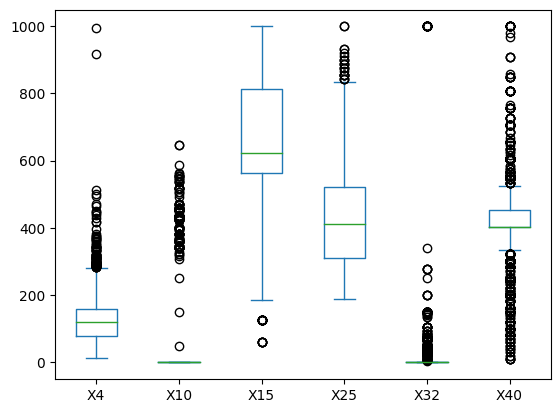

In [151]:
ada_train_data[numerical_cols].plot(kind="box")

Evidently we are facing 

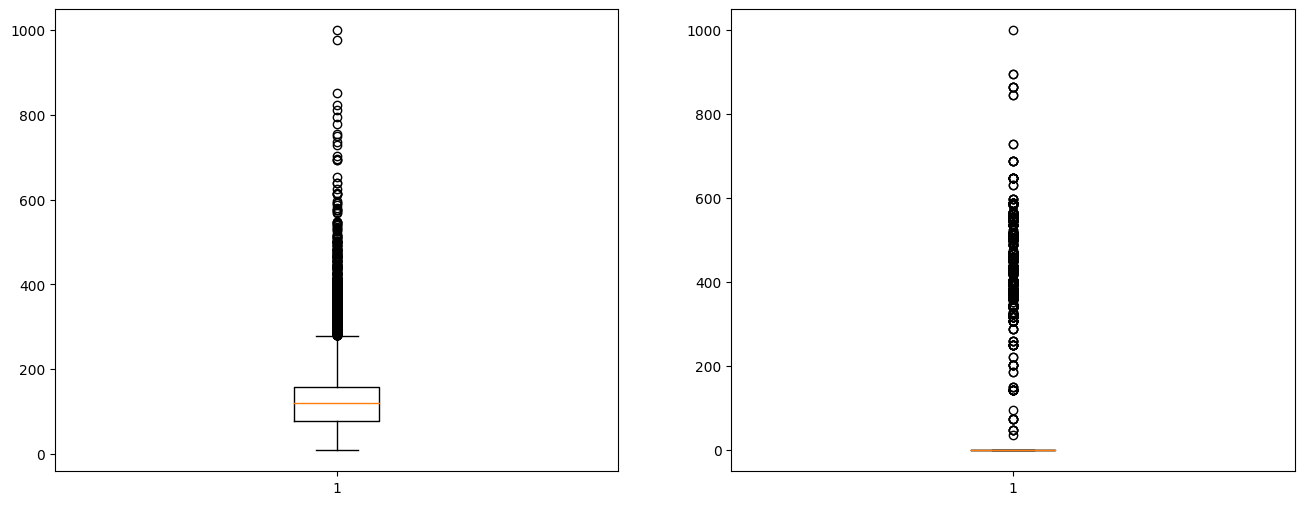

In [152]:
fig,axs=plt.subplots(ncols=2,figsize=(16,6))

axs[0].boxplot(ada_test_data[numerical_cols[0]])
axs[1].boxplot(ada_test_data[numerical_cols[1]])
plt.show()

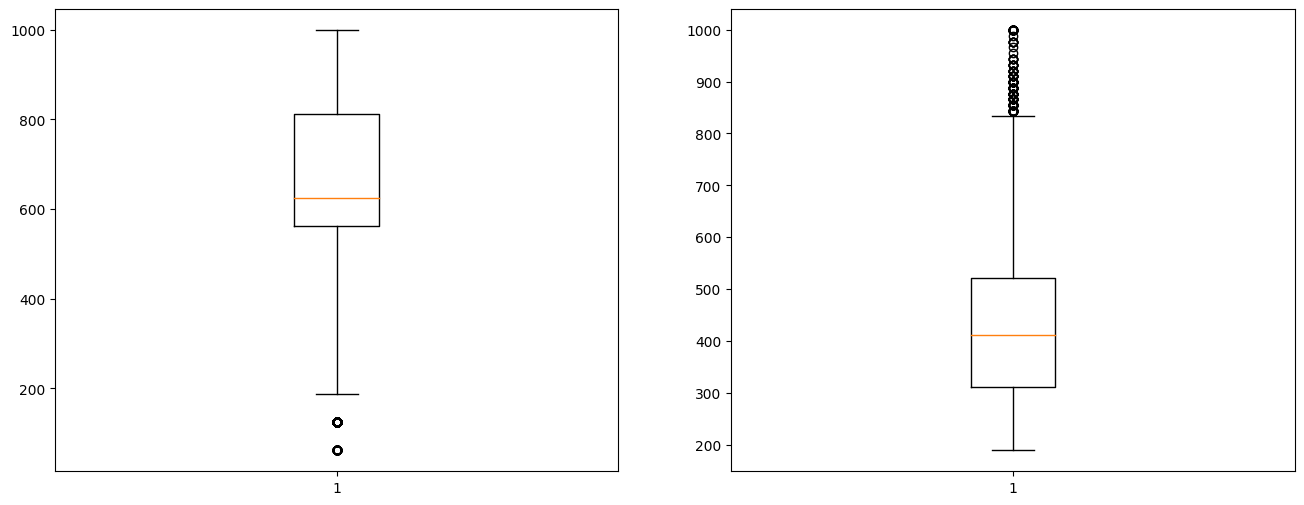

In [153]:
fig,axs=plt.subplots(ncols=2,figsize=(16,6))

axs[0].boxplot(ada_test_data[numerical_cols[2]])
axs[1].boxplot(ada_test_data[numerical_cols[3]])
plt.show()

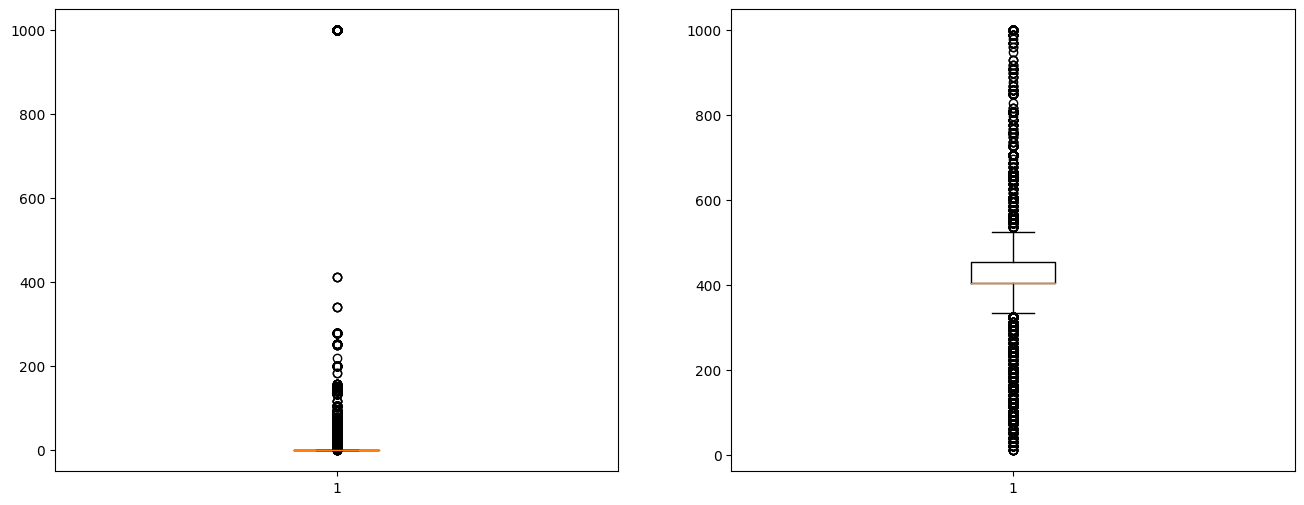

In [154]:
fig,axs=plt.subplots(ncols=2,figsize=(16,6))

axs[0].boxplot(ada_test_data[numerical_cols[4]])
axs[1].boxplot(ada_test_data[numerical_cols[5]])
plt.show()

### Outlier handling

According to the expert of data, outliers is the bigest problem that can introduce biais in analysis and hide generally tendancy most of time especially when data size is small.

There many scenarios that can worthy and very bad but there not pre-defined strategies to get directly the best strategies to handle outliers. Even if, we have this problem; according to problematic some strategies will be more useful than others.

- Filtered test data set to avoid outliers
- 

In [155]:
ada_train_data.nunique().max(),ada_train_data.nunique().min()

(330, 1)

In [156]:
ada_train_data.X21.unique(),ada_valid_data.X21.unique(),ada_test_data.X21.unique()

(array([0]), array([0]), array([0]))

In [157]:
#The column contains just a unique value then it's not useful for discrimination

ada_train_data=ada_train_data.drop(columns=['X21'])
ada_valid_data=ada_valid_data.drop(columns=['X21'])
ada_test_data=ada_test_data.drop(columns=['X21'])

In [158]:
def get_percentage_of_outlier(df):

    numerical_cols=df.columns[df.nunique()>2]
    
    n=df.shape[0]

    outlier_size={}
 
    for col in numerical_cols:

        q1=df[col].quantile(0.25)
        q3=df[col].quantile(0.75)
        IQR=q3-q1

        outliers_shape=df[(df[col]<q1-1.5*IQR)].shape[0] + df[(df[col]>q3+1.5*IQR)].shape[0]

        outlier_size[col]=outliers_shape

    return outlier_size

In [159]:
get_percentage_of_outlier(ada_train_data)

{'X4': 98, 'X10': 193, 'X15': 25, 'X25': 24, 'X32': 336, 'X40': 1108}

### Modelisation

In [160]:
Classifiers=[KNeighborsClassifier,
             LogisticRegression,
             DecisionTreeClassifier,
             GaussianNB,
             LinearDiscriminantAnalysis]

In [161]:
ada_train_data.shape,ada_train_label.shape

((4147, 47), (4147, 1))

#### Before outlier handling

In [162]:
### Data Normalisation

def normalize_num_cols(df):

    df_standard=df.copy()

    standardizing=StandardScaler()
    
    numerical_cols=df.columns[df.nunique()>2]

    standar_col_num=standardizing.fit_transform(df[numerical_cols])

    df_standard[numerical_cols]=standar_col_num

    return df_standard

In [163]:
def get_accuray(train_set,train_label,valid_set,valid_label,cv=50):

    col=["Name","Accuracy_mean","BER_mean","ROC_mean","Accuracy_std","BER_std","ROC_std"]
    df=pd.DataFrame(columns=col)
    for classifier in Classifiers:
        Name=classifier.__name__
        model=classifier().fit(train_set,train_label)
        y_pred=model.predict(valid_set)
        acc=np.mean(cross_val_score(model,train_set,train_label,scoring="accuracy",cv=cv))
        BER=np.mean(cross_val_score(model,train_set,train_label,scoring="balanced_accuracy",cv=cv))
        ROC=np.mean(cross_val_score(model,train_set,train_label,scoring="roc_auc",cv=cv))

        acc_std=np.std(cross_val_score(model,train_set,train_label,scoring="accuracy",cv=cv))
        BER_std=np.std(cross_val_score(model,train_set,train_label,scoring="balanced_accuracy",cv=cv))
        ROC_std=np.std(cross_val_score(model,train_set,train_label,scoring="roc_auc",cv=cv))
        #acc=metrics.accuracy_score(valid_label,y_pred)
        #BER=metrics.balanced_accuracy_score(valid_label,y_pred)
        #ROC=metrics.roc_auc_score(valid_label,y_pred)

        df1=pd.DataFrame([[Name,acc,BER,ROC,acc_std,BER_std,ROC_std]],columns=col)
        df=df.append(df1)

    return df

In [164]:
accuracy_df=get_accuray(ada_train_data,ada_train_label,ada_valid_data,ada_valid_label)

In [165]:
### For normalized data

ada_train_data_standard=normalize_num_cols(ada_train_data)
ada_valid_data_standard=normalize_num_cols(ada_valid_data)

accuracy_df_stand=get_accuray(ada_train_data_standard,ada_train_label,ada_valid_data_standard,ada_valid_label)

#### After handling

In [166]:
from sklearn.impute import KNNImputer

def replace_outlier(x,min_whisker,max_whisker):

    if x<min_whisker or x>max_whisker:

        x=np.NaN
    
    return x


def fill_outlier(df_ada,method):

    numerical_cols=df_ada.columns[df_ada.nunique()>2]
 
    for col in numerical_cols:

        q1=df_ada[col].quantile(0.25)
        
        q3=df_ada[col].quantile(0.75)

        IQR=q3-q1

        min_whisker=q1-1.5*IQR
        max_whisker=q3+1.5*IQR

        df_ada[col]=df_ada[col].apply(lambda x: replace_outlier(x,min_whisker,max_whisker))

    if method=="mean":
            
        df_ada=df_ada.fillna(df_ada.mean())
        
    if method=="knn":
            
        imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

        df_ada[numerical_cols]=imputer.fit_transform(df_ada[numerical_cols])
    
    return df_ada

In [167]:
ada_train_data=fill_outlier(ada_train_data,method="knn")
ada_valid_data=fill_outlier(ada_valid_data,method="knn")

accuracy_df_outlier_trim=get_accuray(ada_train_data,ada_train_label,ada_valid_data,ada_valid_label)

In [168]:
ada_train_data_standard=normalize_num_cols(ada_train_data)
ada_valid_data_standard=normalize_num_cols(ada_valid_data)

accuracy_df_outlier_trim_stand=get_accuray(ada_train_data_standard,ada_train_label,ada_valid_data_standard,ada_valid_label)

In [169]:
accuracy_df["data"]="raw"
accuracy_df_stand["data"]="raw_standard"
accuracy_df_outlier_trim["data"]="outlier_trimmed by mean"
accuracy_df_outlier_trim_stand["data"]="outlier_trimmed by mean and standard"

accuracies=[accuracy_df,accuracy_df_stand,accuracy_df_outlier_trim,accuracy_df_outlier_trim_stand]

accuracies_df=pd.concat(accuracies)

In [170]:
accuracies_df.sort_values(by="Accuracy_mean",ascending=False)

,Name,Accuracy_mean,BER_mean,ROC_mean,Accuracy_std,BER_std,ROC_std,data
0,LogisticRegression,0.848816,0.769276,0.907785,0.035495,0.058109,0.037259,raw_standard
0,LinearDiscriminantAnalysis,0.843744,0.770718,0.896773,0.038859,0.059454,0.038917,raw
0,LinearDiscriminantAnalysis,0.843744,0.770718,0.896773,0.038859,0.059454,0.038917,raw_standard
0,KNeighborsClassifier,0.835069,0.770662,0.865512,0.034882,0.049328,0.038802,raw_standard
0,LinearDiscriminantAnalysis,0.835066,0.758727,0.882846,0.039611,0.054877,0.041406,outlier_trimmed by mean and standard
0,LinearDiscriminantAnalysis,0.835066,0.758727,0.882846,0.039611,0.054877,0.041406,outlier_trimmed by mean
0,LogisticRegression,0.833864,0.746569,0.886386,0.038389,0.054891,0.039575,outlier_trimmed by mean and standard
0,LogisticRegression,0.833385,0.749486,0.882162,0.038212,0.057221,0.043802,raw
0,LogisticRegression,0.829997,0.740363,0.874823,0.034445,0.052611,0.042350,outlier_trimmed by mean
0,KNeighborsClassifier,0.815783,0.749339,0.843639,0.041793,0.052984,0.049053,outlier_trimmed by mean and standard


We find that the best model is build with standardized row data without outlier trimmed

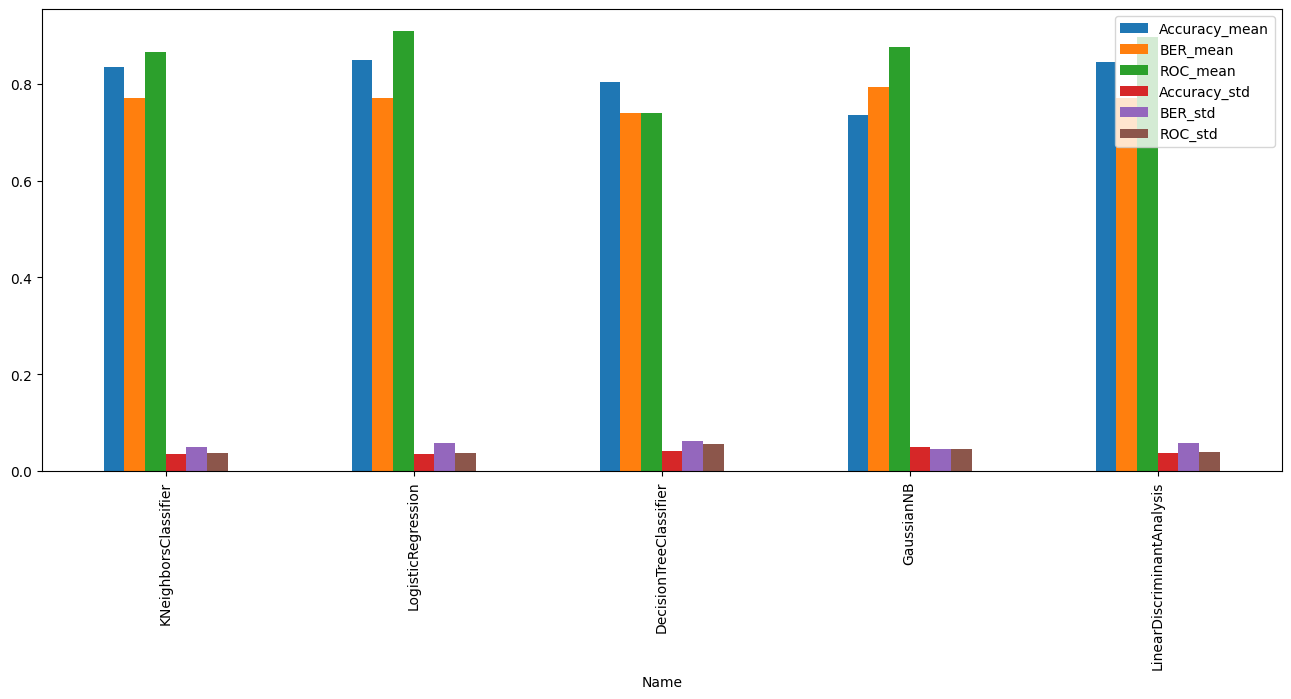

In [171]:
accuracies_df[accuracies_df["data"]=="raw_standard"][["Name","Accuracy_mean","BER_mean","ROC_mean","Accuracy_std","BER_std","ROC_std"]].plot(kind="bar",x="Name",figsize=(16,6))

plt.show()

### Discriminant Analysis

In [195]:
from sklearn import discriminant_analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [198]:
linear_discriminant = discriminant_analysis.LinearDiscriminantAnalysis()
linear_discriminant.fit(X_train, y_train)

predict_lda = linear_discriminant.predict(X_valid)
accuracy_score_lda = accuracy_score(y_valid, predict_lda)
mean_squared_error_lda = mean_squared_error(y_valid, predict_lda)

In [199]:
accuracy_score_lda

0.8433734939759037

In [200]:
mean_squared_error_lda

0.6265060240963856

In [202]:
print(classification_report(y_valid, predict_lda))

              precision    recall  f1-score   support

          -1       0.88      0.91      0.90       312
           1       0.71      0.63      0.67       103

    accuracy                           0.84       415
   macro avg       0.79      0.77      0.78       415
weighted avg       0.84      0.84      0.84       415



### Logistic regression

In [189]:
from sklearn import linear_model

In [192]:
logistic_regression_cv = linear_model.LogisticRegressionCV(max_iter=100000)

logistic_regression_cv.fit(X_train, y_train)

predict_lr = logistic_regression_cv.predict(X_valid)

accuracy_score_lr = accuracy_score(y_valid, predict_lr)
mean_squared_error_lr = mean_squared_error(y_valid, predict_lr)

In [193]:
accuracy_score_lr

0.8481927710843373

In [194]:
mean_squared_error_lr

0.6072289156626506

In [203]:
print(classification_report(y_valid, predict_lr))

              precision    recall  f1-score   support

          -1       0.88      0.92      0.90       312
           1       0.72      0.63      0.67       103

    accuracy                           0.85       415
   macro avg       0.80      0.78      0.79       415
weighted avg       0.84      0.85      0.84       415



### KNN